The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
!pip install git+https://github.com/ipython/matplotlib-inline

# 编译器和解释器


目前为止，本书主要关注的是*命令式编程*（imperative programming）。
命令式编程使用诸如`print`、“`+`”和`if`之类的语句来更改程序的状态。
考虑下面这段简单的命令式程序：


In [ ]:
def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g

print(fancy_func(1, 2, 3, 4))

10


Python是一种*解释型语言*（interpreted language）。因此，当对上面的`fancy_func`函数求值时，它按顺序执行函数体的操作。也就是说，它将通过对`e = add(a, b)`求值，并将结果存储为变量`e`，从而更改程序的状态。接下来的两个语句`f = add(c, d)`和`g = add(e, f)`也将执行类似地操作，即执行加法计算并将结果存储为变量。 

![命令式编程中的数据流](http://d2l.ai/_images/computegraph.svg)


尽管命令式编程很方便，但可能效率不高。一方面原因，Python会单独执行这三个函数的调用，而没有考虑`add`函数在`fancy_func`中被重复调用。如果在一个GPU（甚至多个GPU）上执行这些命令，那么Python解释器产生的开销可能会非常大。此外，它需要保存`e`和`f`的变量值，直到`fancy_func`中的所有语句都执行完毕。这是因为程序不知道在执行语句`e = add(a, b)`和`f = add(c, d)`之后，其他部分是否会使用变量`e`和`f`。

## 符号式编程

考虑另一种选择*符号式编程*（symbolic programming），即代码通常只在完全定义了过程之后才执行计算。这个策略被多个深度学习框架使用，包括Theano和TensorFlow（后者已经获得了命令式编程的扩展）。一般包括以下步骤：

1. 定义计算流程。
1. 将流程编译成可执行的程序。
1. 给定输入，调用编译好的程序执行。

这将允许进行大量的优化。首先，在大多数情况下，我们可以跳过Python解释器。从而消除因为多个更快的GPU与单个CPU上的单个Python线程搭配使用时产生的性能瓶颈。其次，编译器可以将上述代码优化和重写为`print((1 + 2) + (3 + 4))`甚至`print(10)`。因为编译器在将其转换为机器指令之前可以看到完整的代码，所以这种优化是可以实现的。例如，只要某个变量不再需要，编译器就可以释放内存（或者从不分配内存），或者将代码转换为一个完全等价的片段。下面，我们将通过模拟命令式编程来进一步了解符号式编程的概念。


In [ ]:
def add_():
    return '''
def add(a, b):
    return a + b
'''

def fancy_func_():
    return '''
def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
'''

def evoke_():
    return add_() + fancy_func_() + 'print(fancy_func(1, 2, 3, 4))'

prog = evoke_()
print(prog)
y = compile(prog, '', 'exec')
exec(y)


def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
print(fancy_func(1, 2, 3, 4))
10


命令式（解释型）编程和符号式编程的区别如下：

* 命令式编程更容易使用。在Python中，命令式编程的大部分代码都是简单易懂的。命令式编程也更容易调试，这是因为无论是获取和打印所有的中间变量值，或者使用Python的内置调试工具都更加简单。
* 符号式编程运行效率更高，更易于移植。符号式编程更容易在编译期间优化代码，同时还能够将程序移植到与Python无关的格式中，从而允许程序在非Python环境中运行，避免了任何潜在的与Python解释器相关的性能问题。

## 混合式编程

历史上，大部分深度学习框架都在命令式编程与符号式编程之间进行选择。例如，Theano、TensorFlow（灵感来自前者）、Keras和CNTK采用了符号式编程。相反地，Chainer和PyTorch采取了命令式编程。在后来的版本更新中，TensorFlow2.0和Keras增加了命令式编程。


如上所述，PyTorch是基于命令式编程并且使用动态计算图。为了能够利用符号式编程的可移植性和效率，开发人员思考能否将这两种编程模型的优点结合起来，于是就产生了torchscript。torchscript允许用户使用纯命令式编程进行开发和调试，同时能够将大多数程序转换为符号式程序，以便在需要产品级计算性能和部署时使用。


## `Sequential`的混合式编程

要了解混合式编程的工作原理，最简单的方法是考虑具有多层的深层网络。按照惯例，Python解释器需要执行所有层的代码来生成一条指令，然后将该指令转发到CPU或GPU。对于单个的（快速的）计算设备，这不会导致任何重大问题。另一方面，如果我们使用先进的8-GPU服务器，比如AWS P3dn.24xlarge实例，Python将很难让所有的GPU都保持忙碌。在这里，瓶颈是单线程的Python解释器。让我们看看如何通过将`Sequential`替换为`HybridSequential`来解决代码中这个瓶颈。首先，我们定义一个简单的多层感知机。


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l


# 生产网络的工厂模式
def get_net():
    net = nn.Sequential(nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2))
    return net

x = torch.randn(size=(1, 512))
net = get_net()
net(x)

tensor([[ 0.0244, -0.0361]], grad_fn=<AddmmBackward0>)

通过使用`torch.jit.script`函数来转换模型，我们就有能力编译和优化多层感知机中的计算，而模型的计算结果保持不变。


In [ ]:
net = torch.jit.script(net)
net(x)

tensor([[ 0.0244, -0.0361]], grad_fn=<AddmmBackward0>)

我们编写与之前相同的代码，再使用`torch.jit.script`简单地转换模型，当完成这些任务后，网络就将得到优化（我们将在下面对性能进行基准测试）。


### 通过混合式编程加速

为了证明通过编译获得了性能改进，我们比较了混合编程前后执行`net(x)`所需的时间。让我们先定义一个度量时间的类，它在本章中在衡量（和改进）模型性能时将非常有用。


In [ ]:
class Benchmark:
    """用于测量运行时间"""
    def __init__(self, description='Done'):
        self.description = description

    def __enter__(self):
        self.timer = d2l.Timer()
        return self

    def __exit__(self, *args):
        print(f'{self.description}: {self.timer.stop():.4f} sec')

现在我们可以调用网络两次，一次使用torchscript，一次不使用torchscript。


In [ ]:
net = get_net()
with Benchmark('无torchscript'):
    for i in range(1000): net(x)

net = torch.jit.script(net)
with Benchmark('有torchscript'):
    for i in range(1000): net(x)

无torchscript: 1.8929 sec


有torchscript: 1.8184 sec


如以上结果所示，在`nn.Sequential`的实例被函数`torch.jit.script`脚本化后，通过使用符号式编程提高了计算性能。


### 序列化


编译模型的好处之一是我们可以将模型及其参数序列化（保存）到磁盘。这允许这些训练好的模型部署到其他设备上，并且还能方便地使用其他前端编程语言。同时，通常编译模型的代码执行速度也比命令式编程更快。让我们看看`save`的实际功能。


In [ ]:
net.save('my_mlp')
!ls -lh my_mlp*

-rw-rw-r-- 1 d2l-worker d2l-worker 651K Jul 31 02:39 my_mlp


# 异步计算

今天的计算机是高度并行的系统，由多个CPU核、多个GPU、多个处理单元组成。通常每个CPU核有多个线程，每个设备通常有多个GPU，每个GPU有多个处理单元。总之，我们可以同时处理许多不同的事情，并且通常是在不同的设备上。不幸的是，Python并不善于编写并行和异步代码，至少在没有额外帮助的情况下不是好选择。归根结底，Python是单线程的，将来也是不太可能改变的。因此在诸多的深度学习框架中，MXNet和TensorFlow之类则采用了一种*异步编程*（asynchronous programming）模型来提高性能，而PyTorch则使用了Python自己的调度器来实现不同的性能权衡。对于PyTorch来说GPU操作在默认情况下是异步的。当你调用一个使用GPU的函数时，操作会排队到特定的设备上，但不一定要等到以后才执行。这允许我们并行执行更多的计算，包括在CPU或其他GPU上的操作。

因此，了解异步编程是如何工作的，通过主动地减少计算需求和相互依赖，有助于我们开发更高效的程序。这使我们能够减少内存开销并提高处理器利用率。


In [ ]:
import os
import subprocess
import numpy
import torch
from torch import nn
from d2l import torch as d2l

## 通过后端异步处理


作为热身，考虑一个简单问题：我们要生成一个随机矩阵并将其相乘。让我们在NumPy和PyTorch张量中都这样做，看看它们的区别。请注意，PyTorch的`tensor`是在GPU上定义的。


In [ ]:
# GPU计算热身
device = d2l.try_gpu()
a = torch.randn(size=(1000, 1000), device=device)
b = torch.mm(a, a)

with d2l.Benchmark('numpy'):
    for _ in range(10):
        a = numpy.random.normal(size=(1000, 1000))
        b = numpy.dot(a, a)

with d2l.Benchmark('torch'):
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)

numpy: 1.2837 sec
torch: 0.0010 sec


通过PyTorch的基准输出比较快了几个数量级。NumPy点积是在CPU上执行的，而PyTorch矩阵乘法是在GPU上执行的，后者的速度要快得多。但巨大的时间差距表明一定还有其他原因。默认情况下，GPU操作在PyTorch中是异步的。强制PyTorch在返回之前完成所有计算，这种强制说明了之前发生的情况：计算是由后端执行，而前端将控制权返回给了Python。


In [ ]:
with d2l.Benchmark():
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)
    torch.cuda.synchronize(device)

Done: 0.0106 sec


广义上说，PyTorch有一个用于与用户直接交互的前端（例如通过Python），还有一个由系统用来执行计算的后端。如 :numref:`fig_frontends`所示，用户可以用各种前端语言编写PyTorch程序，如Python和C++。不管使用的前端编程语言是什么，PyTorch程序的执行主要发生在C++实现的后端。由前端语言发出的操作被传递到后端执行。后端管理自己的线程，这些线程不断收集和执行排队的任务。请注意，要使其工作，后端必须能够跟踪计算图中各个步骤之间的依赖关系。因此，不可能并行化相互依赖的操作。


![编程语言前端和深度学习框架后端](../img/frontends.png)
:width:`300px`
:label:`fig_frontends`

让我们看另一个简单例子，以便更好地理解依赖关系图。


In [ ]:
x = torch.ones((1, 2), device=device)
y = torch.ones((1, 2), device=device)
z = x * y + 2
z

tensor([[3., 3.]], device='cuda:0')

![后端跟踪计算图中各个步骤之间的依赖关系](http://d2l.ai/_images/asyncgraph.svg)
:label:`fig_asyncgraph`

上面的代码片段在 :numref:`fig_asyncgraph`中进行了说明。每当Python前端线程执行前三条语句中的一条语句时，它只是将任务返回到后端队列。当最后一个语句的结果需要被打印出来时，Python前端线程将等待C++后端线程完成变量`z`的结果计算。这种设计的一个好处是Python前端线程不需要执行实际的计算。因此，不管Python的性能如何，对程序的整体性能几乎没有影响。 :numref:`fig_threading`演示了前端和后端如何交互。

![前端和后端的交互](http://d2l.ai/_images/threading.svg)
:label:`fig_threading`

## 障碍器与阻塞器


## 改进计算


## 小结

* 深度学习框架可以将Python前端的控制与后端的执行解耦，使得命令可以快速地异步插入后端、并行执行。
* 异步产生了一个相当灵活的前端，但请注意：过度填充任务队列可能会导致内存消耗过多。建议对每个小批量进行同步，以保持前端和后端大致同步。
* 芯片供应商提供了复杂的性能分析工具，以获得对深度学习效率更精确的洞察。


## 练习


1. 在CPU上，对本节中相同的矩阵乘法操作进行基准测试。你仍然可以通过后端观察异步吗？


[Discussions](https://discuss.d2l.ai/t/2791)


# 自动并行
:label:`sec_auto_para`

深度学习框架（例如，MxNet和PyTorch）会在后端自动构建计算图。利用计算图，系统可以了解所有依赖关系，并且可以选择性地并行执行多个不相互依赖的任务以提高速度。例如， :numref:`sec_async`中的 :numref:`fig_asyncgraph`独立初始化两个变量。因此，系统可以选择并行执行它们。

通常情况下单个操作符将使用所有CPU或单个GPU上的所有计算资源。例如，即使在一台机器上有多个CPU处理器，`dot` 操作符也将使用所有CPU上的所有核心（和线程）。这样的行为同样适用于单个GPU。因此，并行化对于单设备计算机来说并不是很有用，而并行化对于多个设备就很重要了。虽然并行化通常应用在多个GPU之间，但增加本地CPU以后还将提高少许性能。例如， :cite:`Hadjis.Zhang.Mitliagkas.ea.2016`则把结合GPU和CPU的训练应用到计算机视觉模型中。借助自动并行化框架的便利性，我们可以依靠几行Python代码实现相同的目标。更广泛地考虑，我们对自动并行计算的讨论主要集中在使用CPU和GPU的并行计算上，以及计算和通信的并行化内容。

请注意，我们至少需要两个GPU来运行本节中的实验。


In [ ]:
import torch
from d2l import torch as d2l

## 基于GPU的并行计算

让我们从定义一个具有参考性的用于测试的工作负载开始：下面的`run`函数将执行$10$ 次“矩阵－矩阵”乘法时需要使用的数据分配到两个变量（`x_gpu1`和`x_gpu2`）中，这两个变量分别位于我们选择的不同设备上。


In [ ]:
devices = d2l.try_all_gpus()
def run(x):
    return [x.mm(x) for _ in range(50)]

x_gpu1 = torch.rand(size=(4000, 4000), device=devices[0])
x_gpu2 = torch.rand(size=(4000, 4000), device=devices[1])

现在我们使用函数来数据。我们通过在测量之前预热设备（对设备执行一次传递）来确保缓存的作用不影响最终的结果。`torch.cuda.synchronize()`函数将会等待一个CUDA设备上的所有流中的所有核心的计算完成。函数接受一个`device`参数，代表是哪个设备需要同步。如果device参数是`None`（默认值），它将使用`current_device()`找出的当前设备。


In [ ]:
run(x_gpu1)
run(x_gpu2)  # 预热设备
torch.cuda.synchronize(devices[0])
torch.cuda.synchronize(devices[1])

with d2l.Benchmark('GPU1 time'):
    run(x_gpu1)
    torch.cuda.synchronize(devices[0])

with d2l.Benchmark('GPU2 time'):
    run(x_gpu2)
    torch.cuda.synchronize(devices[1])

GPU1 time: 0.5036 sec


GPU2 time: 0.5141 sec


如果我们删除两个任务之间的`synchronize`语句，系统就可以在两个设备上自动实现并行计算。


In [ ]:
with d2l.Benchmark('GPU1 & GPU2'):
    run(x_gpu1)
    run(x_gpu2)
    torch.cuda.synchronize()

GPU1 & GPU2: 0.5043 sec


在上述情况下，总执行时间小于两个部分执行时间的总和，因为深度学习框架自动调度两个GPU设备上的计算，而不需要用户编写复杂的代码。

## 并行计算与通信

在许多情况下，我们需要在不同的设备之间移动数据，比如在CPU和GPU之间，或者在不同的GPU之间。例如，当我们打算执行分布式优化时，就需要移动数据来聚合多个加速卡上的梯度。让我们通过在GPU上计算，然后将结果复制回CPU来模拟这个过程。


In [ ]:
def copy_to_cpu(x, non_blocking=False):
    return [y.to('cpu', non_blocking=non_blocking) for y in x]

with d2l.Benchmark('在GPU1上运行'):
    y = run(x_gpu1)
    torch.cuda.synchronize()

with d2l.Benchmark('复制到CPU'):
    y_cpu = copy_to_cpu(y)
    torch.cuda.synchronize()

在GPU1上运行: 0.5064 sec

复制到CPU: 2.4303 sec


这种方式效率不高。注意到当列表中的其余部分还在计算时，我们可能就已经开始将`y`的部分复制到CPU了。例如，当我们计算一个小批量的（反传）梯度时。某些参数的梯度将比其他参数的梯度更早可用。因此，在GPU仍在运行时就开始使用PCI-Express总线带宽来移动数据对我们是有利的。在PyTorch中，`to()`和`copy_()`等函数都允许显式的`non_blocking`参数，这允许在不需要同步时调用方可以绕过同步。设置`non_blocking=True`让我们模拟这个场景。


In [ ]:
with d2l.Benchmark('在GPU1上运行并复制到CPU'):
    y = run(x_gpu1)
    y_cpu = copy_to_cpu(y, True)
    torch.cuda.synchronize()

在GPU1上运行并复制到CPU: 1.9874 sec


两个操作所需的总时间少于它们各部分操作所需时间的总和。请注意，与并行计算的区别是通信操作使用的资源：CPU和GPU之间的总线。事实上，我们可以在两个设备上同时进行计算和通信。如上所述，计算和通信之间存在的依赖关系是必须先计算`y[i]`，然后才能将其复制到CPU。幸运的是，系统可以在计算`y[i]`的同时复制`y[i-1]`，以减少总的运行时间。

最后，我们给出了一个简单的两层多层感知机在CPU和两个GPU上训练时的计算图及其依赖关系的例子，如 :numref:`fig_twogpu`所示。手动调度由此产生的并行程序将是相当痛苦的。这就是基于图的计算后端进行优化的优势所在。

![在一个CPU和两个GPU上的两层的多层感知机的计算图及其依赖关系](http://d2l.ai/_images/twogpu.svg)
:label:`fig_twogpu`

## 小结

* 现代系统拥有多种设备，如多个GPU和多个CPU，还可以并行地、异步地使用它们。
* 现代系统还拥有各种通信资源，如PCI Express、存储（通常是固态硬盘或网络存储）和网络带宽，为了达到最高效率可以并行使用它们。
* 后端可以通过自动化地并行计算和通信来提高性能。

## 练习

1. 在本节定义的`run`函数中执行了八个操作，并且操作之间没有依赖关系。设计一个实验，看看深度学习框架是否会自动地并行地执行它们。
1. 当单个操作符的工作量足够小，即使在单个CPU或GPU上，并行化也会有所帮助。设计一个实验来验证这一点。
1. 设计一个实验，在CPU和GPU这两种设备上使用并行计算和通信。
1. 使用诸如NVIDIA的[Nsight](https://developer.nvidia.com/nsight-compute-2019_5) 之类的调试器来验证你的代码是否有效。
1. 设计并实验具有更加复杂的数据依赖关系的计算任务，以查看是否可以在提高性能的同时获得正确的结果。


[Discussions](https://discuss.d2l.ai/t/2794)


# 硬件
:label:`sec_hardware`

很好地理解算法和模型才可以捕获统计方面的问题，构建出具有出色性能的系统。同时，至少对底层硬件有一定的了解也是必不可少的。本节不能替代硬件和系统设计的相关课程。相反，本节的内容可以作为理解某些算法为什么比其他算法更高效以及如何实现良好吞吐量的起点。一个好的设计可以很容易地在性能上造就数量级的差异，这也是后续产生的能够训练网络（例如，训练时间为$1$周）和无法训练网络（训练时间为$3$个月，导致错过截止期）之间的差异。我们先从计算机的研究开始。然后深入查看CPU和GPU。最后，再查看数据中心或云中的多台计算机的连接方式。

![每个程序员都应该知道的延迟数字](../img/latencynumbers.png)
:label:`fig_latencynumbers`

你也可以通过 :numref:`fig_latencynumbers`进行简单的了解，图片源自科林·斯科特的[互动帖子](https://people.eecs.berkeley.edu/~rcs/research/interactive_latency.html)，在帖子中很好地概述了过去十年的进展。原始的数字是取自于杰夫迪恩的[Stanford讲座](https://static.googleusercontent.com/media/research.google.com/en//people/jeff/Stanford-DL-Nov-2010.pdf)。下面的讨论解释了这些数字的一些基本原理，以及它们如何指导我们去设计算法。下面的讨论是非常笼统和粗略的。很显然，它并不能代替一门完整的课程，而只是为了给统计建模者提供足够的信息，让他们做出合适的设计决策。对于计算机体系结构的深入概述，我们建议读者参考 :cite:`Hennessy.Patterson.2011`或关于该主题的最新课程，例如[Arste Asanovic](http://inst.eecs.berkeley.edu/~cs152/sp19/)。

## 计算机

大多数深度学习研究者和实践者都可以使用一台具有相当数量的内存、计算资源、某种形式的加速器（如一个或者多个GPU）的计算机。计算机由以下关键部件组成：

* 一个处理器（也被称为CPU），它除了能够运行操作系统和许多其他功能之外，还能够执行我们给它的程序，通常由$8$个或更多个核心组成。
* 内存（随机访问存储，RAM）用于存储和检索计算结果，如权重向量和激活参数，以及训练数据。
* 一个或多个以太网连接，速度从1GB/s到100GB/s不等。在高端服务器上可能用到更高级的互连。
* 高速扩展总线（PCIe）用于系统连接一个或多个GPU。服务器最多有$8$个加速卡，通常以更高级的拓扑方式连接，而桌面系统则有$1$个或$2$个加速卡，具体取决于用户的预算和电源负载的大小。
* 持久性存储设备，如磁盘驱动器、固态驱动器，在许多情况下使用高速扩展总线连接。它为系统需要的训练数据和中间检查点需要的存储提供了足够的传输速度。

![计算机组件的连接](../img/mobo-symbol.svg)
:label:`fig_mobo-symbol`

如 :numref:`fig_mobo-symbol`所示，高速扩展总线由直接连接到CPU的多个通道组成，将CPU与大多数组件（网络、GPU和存储）连接在一起。例如，AMD的Threadripper3有$64$个PCIe4.0通道，每个通道都能够双向传输16Gbit/s的数据。内存直接连接到CPU，总带宽高达100GB/s。

当我们在计算机上运行代码时，我们需要将数据转移到处理器上（CPU或GPU）执行计算，然后将结果从处理器移回到随机访问存储和持久存储器中。因此，为了获得良好的性能，我们需要确保每一步工作都能无缝链接，而不希望系统中的任何一部分成为主要的瓶颈。例如，如果不能快速加载图像，那么处理器就无事可做。同样地，如果不能快速移动矩阵到CPU（或GPU）上，那么CPU（或GPU）就会无法全速运行。最后，如果希望在网络上同步多台计算机，那么网络就不应该拖累计算速度。一种选择是通信和计算交错进行。接下来，我们将详细地了解各个组件。

## 内存

最基本的内存主要用于存储需要随时访问的数据。目前，CPU的内存通常为[DDR4](https://en.wikipedia.org/wiki/DDR4_SDRAM)类型，每个模块提供20-25Gb/s的带宽。每个模块都有一条$64$位宽的总线。通常使用成对的内存模块来允许多个通道。CPU有$2$到$4$个内存通道，也就是说，它们内存带宽的峰值在40GB/s到100GB/s之间。一般每个通道有两个物理存储体（bank）。例如AMD的Zen 3 Threadripper有$8$个插槽。

虽然这些数字令人印象深刻，但实际上它们只能说明了一部分故事。当我们想要从内存中读取一部分内容时，我们需要先告诉内存模块在哪里可以找到信息。也就是说，我们需要先将*地址*（address）发送到RAM。然后我们可以选择只读取一条$64$位记录还是一长串记录。后者称为*突发读取*（burst read）。概括地说，向内存发送地址并设置传输大约需要100ns（细节取决于所用内存芯片的特定定时系数），每个后续传输只需要0.2ns。总之，第一次读取的成本是后续读取的500倍！请注意，我们每秒最多可以执行一千万次随机读取。这说明应该尽可能地避免随机内存访问，而是使用突发模式读取和写入。

当考虑到我们拥有多个物理存储体时，事情就更加复杂了。每个存储体大部分时候都可以独立地读取内存。这意味着两件事。一方面，如果随机读操作均匀分布在内存中，那么有效的随机读操作次数将高达4倍。这也意味着执行随机读取仍然不是一个好主意，因为突发读取的速度也快了4倍。另一方面，由于内存对齐是$64$位边界，因此最好将任何数据结构与相同的边界对齐。当设置了适当的标志时，编译器基本上就是[自动化](https://en.wikipedia.org/wiki/Data_structure_alignment)地执行对齐操作。我们鼓励好奇的读者回顾一下[Zeshan Chishti关于DRAM的讲座](http://web.cecs.pdx.edu/~zeshan/ece585_lec5.pdf)。

因为GPU的处理单元比CPU多得多，因此它对内存带宽的需要也更高。解决这种问题大体上有两种选择。首要方法是使内存总线变得更宽。例如：NVIDIA的RTX 2080Ti有一条$352$位宽的总线，这样就可以同时传输更多的信息。再有方法就是在GPU中使用特定的高性能内存。一种选择是如NVIDIA的消费级设备RTX和Titan系列中通常使用[GDDR6](https://en.wikipedia.org/wiki/GDDR6_SDRAM）芯片，其总带宽超过500GB/s。另一种选择是使用HBM（高带宽存储器)模块。这些模块使用截然不同的接口在专用硅片上与GPU直接连在一起。这导致其非常昂贵，通常仅限于在高端服务器的芯片上使用，如NVIDIA Volta V100系列的加速卡。

GPU内存的带宽要求甚至更高，因为它们的处理单元比CPU多得多。总的来说，解决这些问题有两种选择。首先是使内存总线变得更宽。例如，NVIDIA的RTX 2080Ti有一条352位宽的总线。这样就可以同时传输更多的信息。其次，GPU使用特定的高性能内存。消费级设备，如NVIDIA的RTX和Titan系列，通常使用[GDDR6](https://en.wikipedia.org/wiki/GDDR6_SDRAM）芯片，总带宽超过500GB/s。另一种选择是使用HBM（高带宽存储器)模块。它们使用截然不同的接口，直接与专用硅片上的GPU连接。这使得它们非常昂贵，通常仅限于高端服务器芯片，如NVIDIA Volta V100系列加速卡。毫不意外的是GPU的内存通常比CPU的内存小得多，因为前者的成本更高。就目的而言，它们的性能与特征大体上是相似的，只是GPU的速度更快。就本书而言，我们完全可以忽略细节，因为这些技术只在调整GPU核心以获得高吞吐量时才起作用。

## 存储器

我们看到随机访问存储的一些关键特性是 *带宽*（bandwidth）和 *延迟*（latency）。存储设备也是如此，只是不同设备之间的特性差异可能更大。

### 硬盘驱动器

*硬盘驱动器*（hard disk drive，HDD）已经使用了半个多世纪。简单的说，它们包含许多旋转的盘片，这些盘片的磁头可以放置在任何给定的磁道上进行读写。高端磁盘在$9$个盘片上可容纳高达16TB的容量。硬盘的主要优点之一是相对便宜，而它们的众多缺点之一是典型的灾难性故障模式和相对较高的读取延迟。

要理解后者，请了解一个事实即硬盘驱动器的转速大约为7200RPM（每分钟转数）。它们如果转速再快些，就会由于施加在碟片上的离心力而破碎。在访问磁盘上的特定扇区时，还有一个关键问题：需要等待碟片旋转到位（可以移动磁头，但是无法对磁盘加速）。因此，可能需要$8$毫秒才能使用请求的数据。一种常见的描述方式是，硬盘驱动器可以以大约100IOPs（每秒输入/输出操作）的速度工作，并且在过去二十年中这个数字基本上没变。同样糟糕的是，带宽（大约为100-200MB/s）也很难增加。毕竟，每个磁头读取一个磁道的比特，因此比特率只随信息密度的平方根缩放。因此，对于非常大的数据集，HDD正迅速降级为归档存储和低级存储。

### 固态驱动器

固态驱动器（solid state drives，SSD）使用闪存持久地存储信息。这允许更快地访问存储的记录。现代的固态驱动器的IOPs可以达到$10$万到$50$万，比硬盘驱动器快3个数量级。而且，它们的带宽可以达到1-3GB/s，比硬盘驱动器快一个数量级。这些改进听起来好的难以置信，而事实上受固态驱动器的设计方式，它仍然存在下面的附加条件：

* 固态驱动器以块的方式（256KB或更大）存储信息。块只能作为一个整体来写入，因此需要耗费大量的时间，导致固态驱动器在按位随机写入时性能非常差。而且通常数据写入需要大量的时间还因为块必须被读取、擦除，然后再重新写入新的信息。如今固态驱动器的控制器和固件已经开发出了缓解这种情况的算法。尽管有了算法，写入速度仍然会比读取慢得多，特别是对于QLC（四层单元）固态驱动器。提高性能的关键是维护操作的“队列”，在队列中尽可能地优先读取和写入大的块。
* 固态驱动器中的存储单元磨损得比较快（通常在几千次写入之后就已经老化了）。磨损程度保护算法能够将退化平摊到许多单元。也就是说，不建议将固态驱动器用于交换分区文件或大型日志文件。
* 最后，带宽的大幅增加迫使计算机设计者将固态驱动器与PCIe总线相连接，这种驱动器称为NVMe（非易失性内存增强），其最多可以使用$4$个PCIe通道。在PCIe4.0上最高可达8GB/s。

### 云存储

云存储提供了一系列可配置的性能。也就是说，虚拟机的存储在数量和速度上都能根据用户需要进行动态分配。我们建议用户在延迟太高时（例如，在训练期间存在许多小记录时）增加IOPs的配置数。

## CPU

中央处理器（central processing unit，CPU）是任何计算机的核心。它们由许多关键组件组成：*处理器核心*（processor cores）用于执行机器代码的、*总线*（bus）用于连接不同组件（注意，总线会因为处理器型号、各代产品和供应商之间的特定拓扑结构有明显不同）和*缓存*（cach）相比主内存实现更高的读取带宽和更低的延迟内存访问。最后，因为高性能线性代数和卷积运算常见于媒体处理和机器学习中，所以几乎所有的现代CPU都包含*向量处理单元*（vector processing unit）为这些计算提供辅助。

![Intel Skylake消费级四核CPU](http://d2l.ai/_images/skylake.svg)
:label:`fig_skylake`

 :numref:`fig_skylake`描述了Intel Skylake消费级四核CPU。它包含一个集成GPU、缓存和一个连接四个核心的环总线。例如：以太网、WiFi、蓝牙、SSD控制器和USB这些外围设备要么是芯片组的一部分，要么通过PCIe直接连接到CPU。

### 微体系结构

每个处理器核心都由一组相当复杂的组件组成。虽然不同时代的产品和供应商的细节有所不同，但基本功能都是标准的。前端加载指令并尝试预测将采用哪条路径（例如，为了控制流），然后将指令从汇编代码解码为微指令。汇编代码通常不是处理器执行的最低级别代码，而复杂的微指令却可以被解码成一组更低级的操作，然后由实际的执行核心处理。通常执行核心能够同时执行许多操作，例如， :numref:`fig_cortexa77`的ARM Cortex A77核心可以同时执行多达$8$个操作。

![ARM Cortex A77微体系结构](http://d2l.ai/_images/a77.svg)
:label:`fig_cortexa77`

这意味着高效的程序可以在每个时钟周期内执行多条指令，前提是这些指令可以独立执行。不是所有的处理单元都是平等的。一些专用于处理整数指令，而另一些则针对浮点性能进行了优化。为了提高吞吐量，处理器还可以在分支指令中同时执行多条代码路径，然后丢弃未选择分支的结果。这就是为什么前端的分支预测单元很重要，因为只有最有希望的路径才会被继续执行。

### 矢量化

深度学习的计算量非常大。因此，为了满足机器学习的需要，CPU需要在一个时钟周期内执行许多操作。这种执行方式是通过向量处理单元实现的。这些处理单元有不同的名称:在ARM上叫做NEON,在x86上被称为[AVX2](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions)。一个常见的功能是它们能够执行单指令多数据（single instruction multiple data，SIMD）操作。 :numref:`fig_neon128`显示了如何在ARM上的一个时钟周期中完成$8$个整数加法。

![128位NEON矢量化](http://d2l.ai/_images/neon128.svg)
:label:`fig_neon128`

根据体系结构的选择，此类寄存器最长可达$512$位，最多可组合$64$对数字。例如，我们可能会将两个数字相乘，然后与第三个数字相加，这也称为乘加融合（fused multiply-add）。Intel的[OpenVino](https://01.org/openvinotoolkit)就是使用这些处理器来获得可观的吞吐量，以便在服务器级CPU上进行深度学习。不过请注意，这个数字与GPU的能力相比则相形见绌。例如，NVIDIA的RTX 2080Ti拥有$4352$个CUDA核心，每个核心都能够在任何时候处理这样的操作。

### 缓存

考虑以下情况：我们有一个中等规模的$4$核心的CPU，如 :numref:`fig_skylake`所示，运行在2GHz频率。此外，假设向量处理单元启用了$256$位带宽的AVX2，其IPC（指令/时钟）计数为1。进一步假设从内存中获取用于AVX2操作的指令至少需要一个寄存器。这意味着CPU每个时钟周期需要消耗$4 \times 256 \text{ bit} = 128 \text{ bytes}$的数据。除非我们能够每秒向处理器传输$2 \times 10^9 \times 128 = 256 \times 10^9$字节，否则用于处理的数据将会不足。不幸的是，这种芯片的存储器接口仅支持20-40Gb/s的数据传输，即少了一个数量级。解决方法是尽可能避免从内存中加载新数据，而是将数据放在CPU的缓存上。这就是使用缓存的地方。通常使用以下名称或概念：

* **寄存器**，严格来说不是缓存的一部分，用于帮助组织指令。也就是说，寄存器是CPU可以以时钟速度访问而没有延迟的存储位置。CPU有几十个寄存器，因此有效地使用寄存器取决于编译器（或程序员）。例如，C语言有一个`register`关键字。
* **一级缓存**是应对高内存带宽要求的第一道防线。一级缓存很小（常见的大小可能是32-64KB），内容通常分为数据和指令。当数据在一级缓存中被找到时，其访问速度非常快，如果没有在那里找到，搜索将沿着缓存层次结构向下寻找。
* **二级缓存**是下一站。根据架构设计和处理器大小的不同，它们可能是独占的也可能是共享的。即它们可能只能由给定的核心访问，或者在多个核心之间共享。二级缓存比一级缓存大（通常每个核心256-512KB），而速度也更慢。此外，我们首先需要检查以确定数据不在一级缓存中，才会访问二级缓存中的内容，这会增加少量的额外延迟。
* **三级缓存**在多个核之间共享，并且可以非常大。AMD的EPYC 3服务器的CPU在多个芯片上拥有高达256MB的高速缓存。更常见的数字在4-8MB范围内。

预测下一步需要哪个存储设备是优化芯片设计的关键参数之一。例如，建议以*向前*的方向遍历内存，因为大多数缓存算法将试图*向前读取*（read forward）而不是向后读取。同样，将内存访问模式保持在本地也是提高性能的一个好方法。

添加缓存是一把双刃剑。一方面，它能确保处理器核心不缺乏数据。但同时，它也增加了芯片尺寸，消耗了原本可以用来提高处理能力的面积。此外，*缓存未命中* 的代价可能会很昂贵。考虑最坏的情况，如 :numref:`fig_falsesharing`所示的*错误共享*（false sharing）。当处理器$1$上的线程请求数据时，内存位置缓存在处理器$0$上。为了满足获取需要，处理器$0$需要停止它正在做的事情，将信息写回主内存，然后让处理器$1$从内存中读取它。在此操作期间，两个处理器都需要等待。与高效的单处理器实现相比，这种代码在多个处理器上运行的速度可能要慢得多。这就是为什么缓存大小（除了物理大小之外）有实际限制的另一个原因。

![错误共享（图片由英特尔提供）](http://d2l.ai/_images/falsesharing.svg)
:label:`fig_falsesharing`

## GPU和其他加速卡

毫不夸张地说，如果没有GPU，深度学习就不会成功。基于同样的原因，有理由认为GPU制造商的财富由于深度学习而显著增加。这种硬件和算法的协同进化导致了这样一种情况：无论好坏，深度学习都是更可取的统计建模范式。因此，了解GPU和其他加速卡（如TPU :cite:`Jouppi.Young.Patil.ea.2017`）的具体好处是值得的。

值得注意的是，在实践中经常会有这样一个判别：加速卡是为训练还是推断而优化的。对于后者，我们只需要计算网络中的前向传播。而反向传播不需要存储中间数据。还有，我们可能不需要非常精确的计算（FP16或INT8通常就足够了）。对于前者，即训练过程中需要存储所有的中间结果用来计算梯度。而且，累积梯度也需要更高的精度，以避免数值下溢（或溢出）。这意味着最低要求也是FP16（或FP16与FP32的混合精度）。所有这些都需要更快、更大的内存（HBM2或者GDDR6）和更高的处理能力。例如，NVIDIA优化了[Turing](https://devblogs.nvidia.com/nvidia-turing-architecture-in-depth/) T4 GPU用于推断和V100 GPU用于训练。

回想一下如 :numref:`fig_neon128`所示的矢量化。处理器核心中添加向量处理单元可以显著提高吞吐量。例如，在 :numref:`fig_neon128`的例子中，我们能够同时执行$16$个操作。首先，如果我们添加的运算不仅优化了向量运算，而且优化了矩阵运算，会有什么好处？稍后我们将讨论基于这个策略引入的张量核（tensor cores）。第二，如果我们增加更多的核心呢？简而言之，以上就是GPU设计决策中的两种策略。 :numref:`fig_turing_processing_block`给出了基本处理块的概述。它包含$16$个整数单位和$16$个浮点单位。除此之外，两个张量核加速了与深度学习相关的附加操作的狭窄的子集。每个流式多处理器都由这样的四个块组成。

![NVIDIA Turing处理块（图片由英伟达提供）](../img/turing-processing-block.png)
:width:`150px`
:label:`fig_turing_processing_block`

接下来，将$12$ 个流式多处理器分组为图形处理集群，这些集群构成了高端TU102处理器。充足的内存通道和二级缓存完善了配置。 :numref:`fig_turing`有相关的细节。设计这种设备的原因之一是可以根据需要独立地添加或删除模块，从而满足设计更紧凑的芯片和处理良品率问题（故障模块可能无法激活）的需要。幸运的是，在CUDA和框架代码层之下，这类设备的编程对深度学习的临时研究员隐藏得很好。特别是，只要有可用的资源GPU上就可以同时执行多个程序。尽管如此，了解设备的局限性是值得的，以避免对应的设备内存的型号不合适。

![NVIDIA Turing架构（图片由英伟达提供）](../img/turing.png)
:width:`350px`
:label:`fig_turing`

最后值得一提的是*张量核*（tensor core）。它们是最近增加更多优化电路趋势的一个例子，这些优化电路对深度学习特别有效。例如，TPU添加了用于快速矩阵乘法的脉动阵列 :cite:`Kung.1988`，这种设计是为了支持非常小数量（第一代TPU支持数量为1）的大型操作。而张量核是另一个极端。它们针对$4 \times 4$和$16 \times 16$矩阵之间的小型运算进行了优化，具体取决于它们的数值精度。 :numref:`fig_tensorcore`给出了优化的概述。

![NVIDIA Turing架构中的张量核心（图片由英伟达提供）](../img/tensorcore.jpg)
:width:`400px`
:label:`fig_tensorcore`

显然，我们最终会在优化计算时做出某些妥协。其中之一是GPU不太擅长处理稀疏数据和中断。尽管有一些明显的例外，如[Gunrock](https://github.com/gunrock/gunrock) :cite:`Wang.Davidson.Pan.ea.2016`，但GPU擅长的高带宽突发读取操作并不适合稀疏的矩阵和向量的访问模式。访问稀疏数据和处理中断这两个目标是一个积极研究的领域。例如：[DGL](http://dgl.ai)，一个专为图深度学习而设计的库。

## 网络和总线

每当单个设备不足以进行优化时，我们就需要来回传输数据以实现同步处理，于是网络和总线就派上了用场。我们有许多设计参数：带宽、成本、距离和灵活性。应用的末端我们有WiFi，它有非常好的使用范围，非常容易使用（毕竟没有线缆），而且还便宜，但它提供的带宽和延迟相对一般。头脑正常的机器学习研究人员都不会用它来构建服务器集群。在接下来的内容中，我们将重点关注适合深度学习的互连方式。

* **PCIe**，一种专用总线，用于每个通道点到点连接的高带宽需求（在$16$通道插槽中的PCIe4.0上高达32GB/s），延迟时间为个位数的微秒（5μs）。PCIe链接非常宝贵。处理器拥有的数量：AMD的EPYC 3有$128$个通道，Intel的Xeon每个芯片有$48$个通道；在桌面级CPU上，数字分别是$20$（Ryzen9）和$16$（Core i9）。由于GPU​通常有$16$个通道，这就限制了以全带宽与CPU连接的GPU数量。毕竟，它们还需要与其他高带宽外围设备（如存储和以太网）共享链路。与RAM访问一样，由于减少了数据包的开销，因此更适合大批量数据传输。
* **以太网**，连接计算机最常用的方式。虽然它比PCIe慢得多，但它的安装成本非常低，而且具有很强的弹性，覆盖的距离也要长得多。低级服务器的典型带宽为1GBit/s。高端设备（如云中的[C5实例](https://aws.amazon.com/ec2/instance-types/c5/））提供10到100GBit/s的带宽。与以前所有的情况一样，数据传输有很大的开销。请注意，原始以太网几乎从不被直接使用，而是在物理互连之上使用执行的协议（例如UDP或TCP/IP)。这进一步增加了开销。与PCIe类似，以太网旨在连接两个设备，例如计算机和交换机。
* **交换机**，一种连接多个设备的方式，该连接方式下的任何一对设备都可以同时执行（通常是全带宽）点对点连接。例如，以太网交换机可能以高带宽连接$40$台服务器。请注意，交换机并不是传统计算机网络所独有的。甚至PCIe通道也可以是[可交换的](https://www.broadcom.com/products/pcie-switches-bridges/pcie-switches)，例如：[P2实例](https://aws.amazon.com/ec2/instance-types/p2/)就是将大量GPU连接到主机处理器。
* **NVLink**，是PCIe的替代品，适用于非常高带宽的互连。它为每条链路提供高达300Gbit/s的数据传输速率。服务器GPU（Volta V100）有六个链路。而消费级GPU（RTX 2080Ti）只有一个链路，运行速度也降低到100Gbit/s。我们建议使用[NCCL](https://github.com/NVIDIA/nccl)来实现GPU之间的高速数据传输。

## 更多延迟

 :numref:`table_latency_numbers`和 :numref:`table_latency_numbers_tesla`中的小结来自[Eliot Eshelman](https://gist.github.com/eshelman)，他们将数字的更新版本保存到[GitHub gist](https://gist.github.com/eshelman/343a1c46cb3fba142c1afdcdeec17646)。

:常见延迟。

| Action | Time | Notes |
| :----------------------------------------- | -----: | :---------------------------------------------- |
| L1 cache reference/hit                     | 1.5 ns | 4 cycles                                        |
| Floating-point add/mult/FMA                | 1.5 ns | 4 cycles                                        |
| L2 cache reference/hit                     |   5 ns | 12 ~ 17 cycles                                  |
| Branch mispredict                          |   6 ns | 15 ~ 20 cycles                                  |
| L3 cache hit (unshared cache)              |  16 ns | 42 cycles                                       |
| L3 cache hit (shared in another core)      |  25 ns | 65 cycles                                       |
| Mutex lock/unlock                          |  25 ns |                                                 |
| L3 cache hit (modified in another core)    |  29 ns | 75 cycles                                       |
| L3 cache hit (on a remote CPU socket)      |  40 ns | 100 ~ 300 cycles (40 ~ 116 ns)                  |
| QPI hop to a another CPU (per hop)         |  40 ns |                                                 |
| 64MB memory ref. (local CPU)          |  46 ns | TinyMemBench on Broadwell E5-2690v4             |
| 64MB memory ref. (remote CPU)         |  70 ns | TinyMemBench on Broadwell E5-2690v4             |
| 256MB memory ref. (local CPU)         |  75 ns | TinyMemBench on Broadwell E5-2690v4             |
| Intel Optane random write                  |  94 ns | UCSD Non-Volatile Systems Lab                   |
| 256MB memory ref. (remote CPU)        | 120 ns | TinyMemBench on Broadwell E5-2690v4             |
| Intel Optane random read                   | 305 ns | UCSD Non-Volatile Systems Lab                   |
| Send 4KB over 100 Gbps HPC fabric          |   1 μs | MVAPICH2 over Intel Omni-Path                   |
| Compress 1KB with Google Snappy            |   3 μs |                                                 |
| Send 4KB over 10 Gbps ethernet             |  10 μs |                                                 |
| Write 4KB randomly to NVMe SSD             |  30 μs | DC P3608 NVMe SSD (QOS 99% is 500μs)            |
| Transfer 1MB to/from NVLink GPU            |  30 μs | ~33GB/s on NVIDIA 40GB NVLink                 |
| Transfer 1MB to/from PCI-E GPU             |  80 μs | ~12GB/s on PCIe 3.0 x16 link                  |
| Read 4KB randomly from NVMe SSD            | 120 μs | DC P3608 NVMe SSD (QOS 99%)                     |
| Read 1MB sequentially from NVMe SSD        | 208 μs | ~4.8GB/s DC P3608 NVMe SSD                    |
| Write 4KB randomly to SATA SSD             | 500 μs | DC S3510 SATA SSD (QOS 99.9%)                   |
| Read 4KB randomly from SATA SSD            | 500 μs | DC S3510 SATA SSD (QOS 99.9%)                   |
| Round trip within same datacenter          | 500 μs | One-way ping is ~250μs                          |
| Read 1MB sequentially from SATA SSD        |   2 ms | ~550MB/s DC S3510 SATA SSD                    |
| Read 1MB sequentially from disk            |   5 ms | ~200MB/s server HDD                           |
| Random Disk Access (seek+rotation)         |  10 ms |                                                 |
| Send packet CA->Netherlands->CA            | 150 ms |                                                 |
:label:`table_latency_numbers`

:NVIDIA Tesla GPU的延迟.

| Action | Time | Notes |
| :------------------------------ | -----: | :---------------------------------------- |
| GPU Shared Memory access        |  30 ns | 30~90 cycles (bank conflicts add latency) |
| GPU Global Memory access        | 200 ns | 200~800 cycles                            |
| Launch CUDA kernel on GPU       |  10 μs | Host CPU instructs GPU to start kernel    |
| Transfer 1MB to/from NVLink GPU |  30 μs | ~33GB/s on NVIDIA 40GB NVLink           |
| Transfer 1MB to/from PCI-E GPU  |  80 μs | ~12GB/s on PCI-Express x16 link         |
:label:`table_latency_numbers_tesla`

## 小结

* 设备有运行开销。因此，数据传输要争取量大次少而不是量少次多。这适用于RAM、固态驱动器、网络和GPU。
* 矢量化是性能的关键。确保充分了解你的加速器的特定功能。例如，一些Intel Xeon CPU特别适用于INT8操作，NVIDIA Volta GPU擅长FP16矩阵操作，NVIDIA Turing擅长FP16、INT8和INT4操作。
* 在训练过程中数据类型过小导致的数值溢出可能是个问题（在推断过程中则影响不大）。
* 数据混叠现象会导致严重的性能退化。$64$位CPU应该按照$64$位边界进行内存对齐。在GPU上建议保持卷积大小对齐，例如：与张量核对齐。
* 将算法与硬件相匹配（例如，内存占用和带宽）。将命中参数装入缓存后，可以实现很大数量级的加速比。
* 在验证实验结果之前，我们建议先在纸上勾勒出新算法的性能。关注的原因是数量级及以上的差异。
* 使用调试器跟踪调试寻找性能的瓶颈。
* 训练硬件和推断硬件在性能和价格方面有不同的优点。

## 练习

1. 编写C语言来测试访问对齐的内存和未对齐的内存之间的速度是否有任何差异。（提示：小心缓存影响。）
1. 测试按顺序访问或按给定步幅访问内存时的速度差异。
1. 如何测量CPU上的缓存大小？
1. 如何在多个内存通道中分配数据以获得最大带宽？如果你有许多小的线程，你会怎么布置？
1. 一个企业级硬盘正在以10000转/分的速度旋转。在最坏的情况下，硬盘读取数据所需的最短时间是多少（你可以假设磁头几乎是瞬间移动的）？为什么2.5英寸硬盘在商用服务器上越来越流行（相对于3.5英寸硬盘和5.25英寸硬盘）？
1. 假设HDD制造商将存储密度从每平方英寸1 Tbit增加到每平方英寸5 Tbit。在一个2.5英寸的硬盘上，多少信息能够存储一个环中？内轨和外轨有区别吗？
1. 从$8$位数据类型到$16$位数据类型，硅片的数量大约增加了四倍，为什么？为什么NVIDIA会在其图灵GPU中添加INT4运算？
1. 在内存中向前读比向后读快多少？该数字在不同的计算机和CPU供应商之间是否有所不同？为什么？编写C代码进行实验。
1. 磁盘的缓存大小能否测量？典型的硬盘是多少？固态驱动器需要缓存吗？
1. 测量通过以太网发送消息时的数据包开销。查找UDP和TCP/IP连接之间的差异。
1. 直接内存访问允许CPU以外的设备直接向内存写入（和读取）。为什么要这样？
1. 看看Turing T4GPU的性能数字。为什么从FP16到INT8和INT4的性能只翻倍？
1. 一个网络包从旧金山到阿姆斯特丹的往返旅行需要多长时间？提示：你可以假设距离为10000公里。

[Discussions](https://discuss.d2l.ai/t/5717)


# 多GPU训练
:label:`sec_multi_gpu`

到目前为止，我们讨论了如何在CPU和GPU上高效地训练模型，同时在 :numref:`sec_auto_para`中展示了深度学习框架如何在CPU和GPU之间自动地并行化计算和通信，还在 :numref:`sec_use_gpu`中展示了如何使用`nvidia-smi`命令列出计算机上所有可用的GPU。
但是我们没有讨论如何真正实现深度学习训练的并行化。
是否一种方法，以某种方式分割数据到多个设备上，并使其能够正常工作呢？
本节将详细介绍如何从零开始并行地训练网络，
这里需要运用小批量随机梯度下降算法（详见 :numref:`sec_minibatch_sgd`）。
后面我还讲介绍如何使用高级API并行训练网络（请参阅 :numref:`sec_multi_gpu_concise`）。

## 问题拆分

我们从一个简单的计算机视觉问题和一个稍稍过时的网络开始。
这个网络有多个卷积层和汇聚层，最后可能有几个全连接的层，看起来非常类似于LeNet :cite:`LeCun.Bottou.Bengio.ea.1998`或AlexNet :cite:`Krizhevsky.Sutskever.Hinton.2012`。
假设我们有多个GPU（如果是桌面服务器则有$2$个，AWS g4dn.12xlarge上有$4$个，p3.16xlarge上有$8$个，p2.16xlarge上有$16$个）。
我们希望以一种方式对训练进行拆分，为实现良好的加速比，还能同时受益于简单且可重复的设计选择。
毕竟，多个GPU同时增加了内存和计算能力。
简而言之，对于需要分类的小批量训练数据，我们有以下选择。

第一种方法，在多个GPU之间拆分网络。
也就是说，每个GPU将流入特定层的数据作为输入，跨多个后续层对数据进行处理，然后将数据发送到下一个GPU。
与单个GPU所能处理的数据相比，我们可以用更大的网络处理数据。
此外，每个GPU占用的*显存*（memory footprint）可以得到很好的控制，虽然它只是整个网络显存的一小部分。

然而，GPU的接口之间需要的密集同步可能是很难办的，特别是层之间计算的工作负载不能正确匹配的时候，
还有层之间的接口需要大量的数据传输的时候（例如：激活值和梯度，数据量可能会超出GPU总线的带宽）。
此外，计算密集型操作的顺序对于拆分来说也是非常重要的，这方面的最好研究可参见 :cite:`Mirhoseini.Pham.Le.ea.2017`，其本质仍然是一个困难的问题，目前还不清楚研究是否能在特定问题上实现良好的线性缩放。
综上所述，除非存框架或操作系统本身支持将多个GPU连接在一起，否则不建议这种方法。

第二种方法，拆分层内的工作。
例如，将问题分散到$4$个GPU，每个GPU生成$16$个通道的数据，而不是在单个GPU上计算$64$个通道。
对于全连接的层，同样可以拆分输出单元的数量。
 :numref:`fig_alexnet_original`描述了这种设计，其策略用于处理显存非常小（当时为2GB）的GPU。
当通道或单元的数量不太小时，使计算性能有良好的提升。
此外，由于可用的显存呈线性扩展，多个GPU能够处理不断变大的网络。

![由于GPU显存有限，原有AlexNet设计中的模型并行](../img/alexnet-original.svg)
:label:`fig_alexnet_original`

然而，我们需要大量的同步或*屏障操作*（barrier operation），因为每一层都依赖于所有其他层的结果。
此外，需要传输的数据量也可能比跨GPU拆分层时还要大。
因此，基于带宽的成本和复杂性，我们同样不推荐这种方法。

最后一种方法，跨多个GPU对数据进行拆分。
这种方式下，所有GPU尽管有不同的观测结果，但是执行着相同类型的工作。
在完成每个小批量数据的训练之后，梯度在GPU上聚合。
这种方法最简单，并可以应用于任何情况，同步只需要在每个小批量数据处理之后进行。
也就是说，当其他梯度参数仍在计算时，完成计算的梯度参数就可以开始交换。
而且，GPU的数量越多，小批量包含的数据量就越大，从而就能提高训练效率。
但是，添加更多的GPU并不能让我们训练更大的模型。

![在多个GPU上并行化。从左到右：原始问题、网络并行、分层并行、数据并行](http://d2l.ai/_images/splitting.svg)
:label:`fig_splitting`

 :numref:`fig_splitting`中比较了多个GPU上不同的并行方式。
总体而言，只要GPU的显存足够大，数据并行是最方便的。
有关分布式训练分区的详细描述，请参见 :cite:`Li.Andersen.Park.ea.2014`。
在深度学习的早期，GPU的显存曾经是一个棘手的问题，然而如今除了非常特殊的情况，这个问题已经解决。
下面我们将重点讨论数据并行性。

## 数据并行性

假设一台机器有$k$个GPU。
给定需要训练的模型，虽然每个GPU上的参数值都是相同且同步的，但是每个GPU都将独立地维护一组完整的模型参数。
例如， :numref:`fig_data_parallel`演示了在$k=2$时基于数据并行方法训练模型。

![利用两个GPU上的数据，并行计算小批量随机梯度下降](../img/data-parallel.svg)
:label:`fig_data_parallel`

一般来说，$k$个GPU并行训练过程如下：

* 在任何一次训练迭代中，给定的随机的小批量样本都将被分成$k$个部分，并均匀地分配到GPU上。
* 每个GPU根据分配给它的小批量子集，计算模型参数的损失和梯度。
* 将$k$个GPU中的局部梯度聚合，以获得当前小批量的随机梯度。
* 聚合梯度被重新分发到每个GPU中。
* 每个GPU使用这个小批量随机梯度，来更新它所维护的完整的模型参数集。


在实践中请注意，当在$k$个GPU上训练时，需要扩大小批量的大小为$k$的倍数，这样每个GPU都有相同的工作量，就像只在单个GPU上训练一样。
因此，在16-GPU服务器上可以显著地增加小批量数据量的大小，同时可能还需要相应地提高学习率。
还请注意， :numref:`sec_batch_norm`中的批量规范化也需要调整，例如，为每个GPU保留单独的批量规范化参数。

下面我们将使用一个简单网络来演示多GPU训练。


# 多GPU的简洁实现
:label:`sec_multi_gpu_concise`

每个新模型的并行计算都从零开始实现是无趣的。此外，优化同步工具以获得高性能也是有好处的。下面我们将展示如何使用深度学习框架的高级API来实现这一点。数学和算法与 :numref:`sec_multi_gpu`中的相同。不出所料，你至少需要两个GPU来运行本节的代码。


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

## [**简单网络**]

让我们使用一个比 :numref:`sec_multi_gpu`的LeNet更有意义的网络，它依然能够容易地和快速地训练。我们选择的是 :cite:`He.Zhang.Ren.ea.2016`中的ResNet-18。因为输入的图像很小，所以稍微修改了一下。与 :numref:`sec_resnet`的区别在于，我们在开始时使用了更小的卷积核、步长和填充，而且删除了最大汇聚层。


In [ ]:
#@save
def resnet18(num_classes, in_channels=1):
    """稍加修改的ResNet-18模型"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(
        64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

## 网络初始化


我们将在训练回路中初始化网络。请参见 :numref:`sec_numerical_stability`复习初始化方法。


In [ ]:
net = resnet18(10)
# 获取GPU列表
devices = d2l.try_all_gpus()
# 我们将在训练代码实现中初始化网络

## [**训练**]

如前所述，用于训练的代码需要执行几个基本功能才能实现高效并行：

* 需要在所有设备上初始化网络参数。
* 在数据集上迭代时，要将小批量数据分配到所有设备上。
* 跨设备并行计算损失及其梯度。
* 聚合梯度，并相应地更新参数。

最后，并行地计算精确度和发布网络的最终性能。除了需要拆分和聚合数据外，训练代码与前几章的实现非常相似。


In [ ]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    # 在多个GPU上设置模型
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

让我们看看这在实践中是如何运作的。我们先[**在单个GPU上训练网络**]进行预热。


测试精度：0.92，13.7秒/轮，在[device(type='cuda', index=0)]


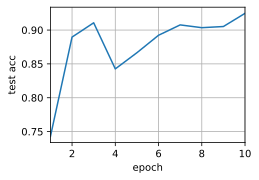

In [ ]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

接下来我们[**使用2个GPU进行训练**]。与 :numref:`sec_multi_gpu`中评估的LeNet相比，ResNet-18的模型要复杂得多。这就是显示并行化优势的地方，计算所需时间明显大于同步参数需要的时间。因为并行化开销的相关性较小，因此这种操作提高了模型的可伸缩性。


测试精度：0.89，8.4秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


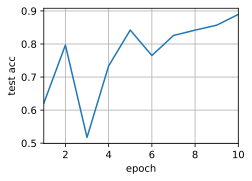

In [ ]:
train(net, num_gpus=2, batch_size=512, lr=0.2)

## 小结


* 神经网络可以在（可找到数据的）单GPU上进行自动评估。
* 每台设备上的网络需要先初始化，然后再尝试访问该设备上的参数，否则会遇到错误。
* 优化算法在多个GPU上自动聚合。


## 练习


1. 本节使用ResNet-18，请尝试不同的迭代周期数、批量大小和学习率，以及使用更多的GPU进行计算。如果使用$16$个GPU（例如，在AWS p2.16xlarge实例上）尝试此操作，会发生什么？
1. 有时候不同的设备提供了不同的计算能力，我们可以同时使用GPU和CPU，那应该如何分配工作？为什么？


[Discussions](https://discuss.d2l.ai/t/2803)


# 参数服务器
:label:`sec_parameterserver`

当我们从一个GPU迁移到多个GPU时，以及再迁移到包含多个GPU的多个服务器时（可能所有服务器的分布跨越了多个机架和多个网络交换机），分布式并行训练算法也需要变得更加复杂。通过细节可以知道，一方面是不同的互连方式的带宽存在极大的区别（例如，NVLink可以通过设置实现跨$6$条链路的高达100GB/s的带宽，16通道的PCIe4.0提供32GB/s的带宽，而即使是高速100GbE以太网也只能提供大约10GB/s的带宽）；另一方面是期望开发者既能完成统计学习建模还精通系统和网络也是不切实际的。

参数服务器的核心思想首先是由 :cite:`Smola.Narayanamurthy.2010`在分布式隐变量模型的背景下引入的。然后，在 :cite:`Ahmed.Aly.Gonzalez.ea.2012`中描述了Push和Pull的语义，又在 :cite:`Li.Andersen.Park.ea.2014`中描述了系统和开源库。下面，我们将介绍用于提高计算效率的组件。

## 数据并行训练

让我们回顾一下在分布式架构中数据并行的训练方法，因为在实践中它的实现相对简单，因此本节将排除其他内容只对其进行介绍。由于当今的GPU拥有大量的显存，因此在实际场景中（不包括图深度学习）只有数据并行这种并行训练策略值得推荐。图 :numref:`fig_parameterserver`描述了在 :numref:`sec_multi_gpu`中实现的数据并行的变体。其中的关键是梯度的聚合需要在GPU 0上完成，然后再将更新后的参数广播给所有GPU。

![左图：单GPU训练；右图：多GPU训练的一个变体：（1）计算损失和梯度，（2）所有梯度聚合在一个GPU上，（3）发生参数更新，并将参数重新广播给所有GPU](http://d2l.ai/_images/ps.svg)
:label:`fig_parameterserver`

回顾来看，选择GPU 0进行聚合似乎是个很随便的决定，当然也可以选择CPU上聚合，事实上只要优化算法支持，在实际操作中甚至可以在某个GPU上聚合其中一些参数，而在另一个GPU上聚合另一些参数。例如，如果有四个与参数向量相关的梯度$\mathbf{g}_1, \ldots, \mathbf{g}_4$，还可以一个GPU对一个$\mathbf{g}_i (i = 1, \ldots, 4$）地进行梯度聚合。

这样的推断似乎是轻率和武断的，毕竟数学应该是逻辑自洽的。但是，我们处理的是如 :numref:`sec_hardware`中所述的真实的物理硬件，其中不同的总线具有不同的带宽。考虑一个如 :numref:`sec_hardware`中所述的真实的$4$路GPU服务器。如果它的连接是特别完整的，那么可能拥有一个100GbE的网卡。更有代表性的数字是1-10GbE范围内，其有效带宽为100MB/s到1GB/s。因为CPU的PCIe通道太少（例如，消费级的Intel CPU有$24$个通道），所以无法直接与所有的GPU相连接，因此需要[multiplexer](https://www.broadcom.com/products/pcie-switches-bridges/pcie-switches)。CPU在16x Gen3链路上的带宽为16GB/s，这也是每个GPU连接到交换机的速度，这意味着GPU设备之间的通信更有效。

![一个4路GPU服务器](../img/bw-hierarchy.svg)
:label:`fig_bw_hierarchy`

为了便于讨论，我们假设所有梯度共需160MB。在这种情况下，将其中$3$个GPU的梯度发送到第$4$个GPU上需要$30$毫秒（每次传输需要$10$毫秒=160MB/16GB/s）。再加上$30$毫秒将权重向量传输回来，得到的结果是总共需要$60$毫秒。如果将所有的数据发送到CPU，总共需要$80$毫秒，其中将有$40$毫秒的惩罚，因为$4$个GPU每个都需要将数据发送到CPU。最后，假设能够将梯度分为$4$个部分，每个部分为$40$MB，现在可以在不同的GPU上同时聚合每个部分。因为PCIe交换机在所有链路之间提供全带宽操作，所以传输需要$2.5\times 3=7.5$毫秒，而不是$30$毫秒，因此同步操作总共需要$15$毫秒。简而言之，一样的参数同步操作基于不同的策略时间可能在$15$毫秒到$80$毫秒之间。 :numref:`fig_ps_distributed`描述了交换参数的不同策略。

![参数同步策略](../img/ps-distributed.svg)
:label:`fig_ps_distributed`

请注意，我们还可以使用另一个工具来改善性能：在深度网络中，从顶部到底部计算所有梯度需要一些时间，因此即使还在忙着为某些参数计算梯度时，就可以开始为准备好的参数同步梯度了。想了解详细信息可以参见 :cite:`Sergeev.Del-Balso.2018`，想知道如何操作可参考[Horovod](https://github.com/horovod/horovod)。

## 环同步（Ring Synchronization）

当谈及现代深度学习硬件的同步问题时，我们经常会遇到大量的定制的网络连接。例如，AWS p3.16xlarge和NVIDIA DGX-2实例中的连接都使用了 :numref:`fig_nvlink`中的结构。每个GPU通过PCIe链路连接到主机CPU，该链路最多只能以16GB/s的速度运行。此外，每个GPU还具有$6$个NVLink连接，每个NVLink连接都能够以300Gbit/s进行双向传输。这相当于每个链路每个方向约$300\div 8\div 2\approx 18 \mathrm{GB/s}$。简言之，聚合的NVLink带宽明显高于PCIe带宽，问题是如何有效地使用它。

![在8台V100 GPU服务器上连接NVLink（图片由英伟达提供）](http://d2l.ai/_images/nvlink.svg)
:label:`fig_nvlink`

 :cite:`Wang.Li.Liberty.ea.2018`的研究结果表明最优的同步策略是将网络分解成两个环，并基于两个环直接同步数据。
 :numref:`fig_nvlink_twoloop`描述了网络可以分解为一个具有双NVLink带宽的环（1-2-3-4-5-6-7-8-1）和一个具有常规带宽的环（1-4-6-3-5-8-2-7-1）。在这种情况下，设计一个高效的同步协议是非常重要的。

![将NVLink网络分解为两个环。](../img/nvlink-twoloop.svg)
:label:`fig_nvlink_twoloop`

考虑下面的思维试验：给定由$n$个计算节点（或GPU）组成的一个环，梯度可以从第一个节点发送到第二个节点，在第二个结点将本地的梯度与传送的梯度相加并发送到第三个节点，依此类推。在$n-1$步之后，可以在最后访问的节点中找到聚合梯度。也就是说，聚合梯度的时间随节点数线性增长。但如果照此操作，算法是相当低效的。归根结底，在任何时候都只有一个节点在通信。如果我们将梯度分为$n$个块，并从节点$i$开始同步块$i$，会怎么样？因为每个块的大小是$1/n$，所以总时间现在是$(n-1)/n \approx 1$。换句话说，当我们增大环的大小时，聚合梯度所花费的时间不会增加。这是一个相当惊人的结果。 :numref:`fig_ringsync`说明了$n=4$个节点上的步骤顺序。

![跨4个节点的环同步。每个节点开始向其左邻居发送部分梯度，直到在其右邻居中找到聚合的梯度](http://d2l.ai/_images/ringsync.svg)
:label:`fig_ringsync`

如果我们使用相同的例子，跨$8$个V100 GPU同步160MB，我们得到的结果大约是$2 \times 160 \mathrm{MB} \div (3 \times18 \mathrm{GB/s}) \approx 6 \mathrm{ms}$。这比使用PCIe总线要好，即使我们现在使用的是$8$个GPU。请注意，这些数字在实践中通常会差一些，因为深度学习框架无法将通信组合成大的突发传输。

注意到有一种常见的误解认为环同步与其他同步算法在本质上是不同的，实际上与简单的树算法相比其唯一的区别是同步路径稍微精细一些。

## 多机训练

新的挑战出现在多台机器上进行分布式训练：我们需要服务器之间相互通信，而这些服务器又只通过相对较低的带宽结构连接，在某些情况下这种连接的速度可能会慢一个数量级，因此跨设备同步是个棘手的问题。毕竟，在不同机器上运行训练代码的速度会有细微的差别，因此如果想使用分布式优化的同步算法就需要*同步*（synchronize）这些机器。
 :numref:`fig_ps_multimachine`说明了分布式并行训练是如何发生的。

1. 在每台机器上读取一组（不同的）批量数据，在多个GPU之间分割数据并传输到GPU的显存中。基于每个GPU上的批量数据分别计算预测和梯度。
2. 来自一台机器上的所有的本地GPU的梯度聚合在一个GPU上（或者在不同的GPU上聚合梯度的某些部分）。
3. 每台机器的梯度被发送到其本地CPU中。
4. 所有的CPU将梯度发送到中央参数服务器中，由该服务器聚合所有梯度。
5. 然后使用聚合后的梯度来更新参数，并将更新后的参数广播回各个CPU中。
6. 更新后的参数信息发送到本地一个（或多个）GPU中。
7. 所有GPU上的参数更新完成。

![多机多GPU分布式并行训练](../img/ps-multimachine.svg)
:label:`fig_ps_multimachine`

以上这些操作似乎都相当简单，而且事实上它们可以在一台机器内高效地执行，但是当我们考虑多台机器时，就会发现中央的参数服务器成为了瓶颈。毕竟，每个服务器的带宽是有限的，因此对于$m$个工作节点来说，将所有梯度发送到服务器所需的时间是$\mathcal{O}(m)$。我们也可以通过将参数服务器数量增加到$n$来突破这一障碍。此时，每个服务器只需要存储$\mathcal{O}(1/n)$个参数，因此更新和优化的总时间变为$\mathcal{O}(m/n)$。这两个数字的匹配会产生稳定的伸缩性，而不用在乎我们需要处理多少工作节点。在实际应用中，我们使用同一台机器既作为工作节点还作为服务器。设计说明请参考 :numref:`fig_ps_multips`（技术细节请参考 :cite:`Li.Andersen.Park.ea.2014`）。特别是，确保多台机器只在没有不合理延迟的情况下工作是相当困难的。我们在下面忽略了关于阻塞的细节，只简单介绍一下同步和异步（unsynchronized）更新。

![上图：单参数服务器是一个瓶颈，因为它的带宽是有限的；下图：多参数服务器使用聚合带宽存储部分参数](../img/ps-multips.svg)
:label:`fig_ps_multips`

## 键值存储

在实践中，实现分布式多GPU训练所需要的步骤绝非易事。这就是公共抽象值得使用的原因，公共抽象即重新定义具有更新语义的*键－值存储*（key-value store）的抽象。

在许多工作节点和许多GPU中，梯度$i$的计算可以定义为

$$\mathbf{g}_{i} = \sum_{k \in \text{workers}} \sum_{j \in \text{GPUs}} \mathbf{g}_{ijk},$$

其中$\mathbf{g}_{ijk}$是在工作节点$k$的GPU$j$上拆分的梯度$i$的一部分。这个运算的关键在于它是一个*交换归约*（commutative reduction），也就是说，它把许多向量变换成一个向量，而运算顺序在完成向量变换时并不重要。这对实现我们的目标来说是非常好的，因为不需要为何时接收哪个梯度进行细粒度的控制。此外，请注意，这个操作在不同的$i$之间是独立的。

这就允许我们定义下面两个操作：*push*（用于累积梯度）和*pull*（用于取得聚合梯度）。因为我们有很多层，也就有很多不同的梯度集合，因此需要用一个键$i$来对梯度建索引。这个与Dynamo :cite:`DeCandia.Hastorun.Jampani.ea.2007`中引入的“键－值存储”之间存在相似性并非巧合。它们两个定义都拥有许多相似的性质，特别是在多个服务器之间分发参数时。

“键－值存储”的push与pull操作描述如下：

* **push（key，value）**将特定的梯度值从工作节点发送到公共存储，在那里通过某种方式（例如，相加）来聚合值。
* **pull（key，value）**从公共存储中取得某种方式（例如，组合来自所有工作节点的梯度）的聚合值。

通过将同步的所有复杂性隐藏在一个简单的push和pull操作背后，我们可以将统计建模人员（他们希望能够用简单的术语表达优化）和系统工程师（他们需要处理分布式同步中固有的复杂性）的关注点解耦。

## 小结

* 同步需要高度适应特定的网络基础设施和服务器内的连接，这种适应会严重影响同步所需的时间。
* 环同步对于p3和DGX-2服务器是最佳的，而对于其他服务器则未必。
* 当添加多个参数服务器以增加带宽时，分层同步策略可以工作的很好。

## 练习

1. 你能进一步提高环同步的性能吗？（提示：你可以双向发送消息。）
1. 在计算仍在进行中，可否允许执行异步通信？它将如何影响性能？
1. 怎样处理在长时间运行的计算过程中丢失了一台服务器这种问题？尝试设计一种容错机制来避免重启计算这种解决方案？

[Discussions](https://discuss.d2l.ai/t/5774)


In [ ]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## [**简单网络**]

我们使用 :numref:`sec_lenet`中介绍的（稍加修改的）LeNet，
从零开始定义它，从而详细说明参数交换和同步。


In [ ]:
# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

## 数据同步

对于高效的多GPU训练，我们需要两个基本操作。
首先，我们需要[**向多个设备分发参数**]并附加梯度（`get_params`）。
如果没有参数，就不可能在GPU上评估网络。
第二，需要跨多个设备对参数求和，也就是说，需要一个`allreduce`函数。


In [ ]:
def get_params(params, device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

通过将模型参数复制到一个GPU。


In [ ]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 权重:', new_params[1])
print('b1 梯度:', new_params[1].grad)

b1 权重: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 梯度: None


由于还没有进行任何计算，因此权重参数的梯度仍然为零。
假设现在有一个向量分布在多个GPU上，下面的[**`allreduce`函数将所有向量相加，并将结果广播给所有GPU**]。
请注意，我们需要将数据复制到累积结果的设备，才能使函数正常工作。


In [ ]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)

通过在不同设备上创建具有不同值的向量并聚合它们。


In [ ]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1])

allreduce之前：
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
allreduce之后：
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


## 数据分发

我们需要一个简单的工具函数，[**将一个小批量数据均匀地分布在多个GPU上**]。
例如，有两个GPU时，我们希望每个GPU可以复制一半的数据。
因为深度学习框架的内置函数编写代码更方便、更简洁，所以在$4 \times 5$矩阵上使用它进行尝试。


In [ ]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


为了方便以后复用，我们定义了可以同时拆分数据和标签的`split_batch`函数。


In [ ]:
#@save
def split_batch(X, y, devices):
    """将X和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

## 训练

现在我们可以[**在一个小批量上实现多GPU训练**]。
在多个GPU之间同步数据将使用刚才讨论的辅助函数`allreduce`和`split_and_load`。
我们不需要编写任何特定的代码来实现并行性。
因为计算图在小批量内的设备之间没有任何依赖关系，因此它是“自动地”并行执行。


In [ ]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce(
                [device_params[c][i].grad for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # 在这里，我们使用全尺寸的小批量

现在，我们可以[**定义训练函数**]。
与前几章中略有不同：训练函数需要分配GPU并将所有模型参数复制到所有设备。
显然，每个小批量都是使用`train_batch`函数来处理多个GPU。
我们只在一个GPU上计算模型的精确度，而让其他GPU保持空闲，尽管这是相对低效的，但是使用方便且代码简洁。


In [ ]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到num_gpus个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # 在GPU0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

让我们看看[**在单个GPU上运行**]效果得有多好。
首先使用的批量大小是$256$，学习率是$0.2$。


测试精度：0.80，2.7秒/轮，在[device(type='cuda', index=0)]


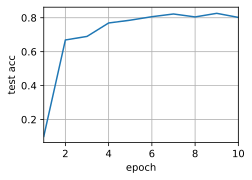

In [ ]:
train(num_gpus=1, batch_size=256, lr=0.2)

保持批量大小和学习率不变，并[**增加为2个GPU**]，我们可以看到测试精度与之前的实验基本相同。
不同的GPU个数在算法寻优方面是相同的。
不幸的是，这里没有任何有意义的加速：模型实在太小了；而且数据集也太小了，在这个数据集中，我们实现的多GPU训练的简单方法受到了巨大的Python开销的影响。
在未来，我们将遇到更复杂的模型和更复杂的并行化方法。
尽管如此，让我们看看Fashion-MNIST数据集上会发生什么。


测试精度：0.84，2.8秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


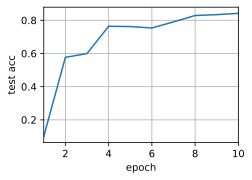

In [ ]:
train(num_gpus=2, batch_size=256, lr=0.2)

## 小结

* 有多种方法可以在多个GPU上拆分深度网络的训练。拆分可以在层之间、跨层或跨数据上实现。前两者需要对数据传输过程进行严格编排，而最后一种则是最简单的策略。
* 数据并行训练本身是不复杂的，它通过增加有效的小批量数据量的大小提高了训练效率。
* 在数据并行中，数据需要跨多个GPU拆分，其中每个GPU执行自己的前向传播和反向传播，随后所有的梯度被聚合为一，之后聚合结果向所有的GPU广播。
* 小批量数据量更大时，学习率也需要稍微提高一些。

## 练习

1. 在$k$个GPU上进行训练时，将批量大小从$b$更改为$k \cdot b$，即按GPU的数量进行扩展。
1. 比较不同学习率时模型的精确度，随着GPU数量的增加学习率应该如何扩展？
1. 实现一个更高效的`allreduce`函数用于在不同的GPU上聚合不同的参数？为什么这样的效率更高？
1. 实现模型在多GPU下测试精度的计算。


[Discussions](https://discuss.d2l.ai/t/2800)
